In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import models
import utils

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

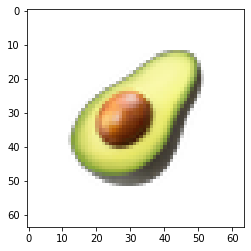

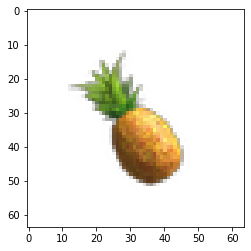

In [2]:
avocado = utils.load_emoji("🥑").to(device)
pineapple = utils.load_emoji("🍍").to(device)

plt.imshow(avocado.transpose(0,2).cpu())
plt.show()
plt.imshow(pineapple.transpose(0,2).cpu())
plt.show()

img_size = 64

In [3]:
n_channels = 16
n_epochs = 2500
lr = 0.001
pool_size = 1024
batch_size = 16
hidden_size=128

image_1 = avocado
image_2 = pineapple

images = torch.stack([image_1,image_2])

model = models.Automata((64, 64), n_channels, 128, device).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

seed_1 = seed.clone()
seed_2 = seed.clone()

seed_1[4,32,32] = 0

seeds = torch.stack([seed_1,seed_2])

pool_initials = seeds.repeat(pool_size//2,1,1,1)
pool_targets = images.repeat(pool_size//2,1,1,1)

pool_target_ids = torch.Tensor([0,1]).repeat(pool_size//2).long()
# 0 for image_1, 1 for image_2
# half image 1, half image 2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
    iterations = random.randint(64,96)

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:batch_size//2]
    max_loss_indices = ranked_loss[batch_size//2:]
    
    replacements = out.detach()
    
    max_loss_targets = target_ids[max_loss_indices]
    
    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image
    
    # low-loss outputs are tasked with mapping
    # the previous output to the same image
    
    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements
    
    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -1.0387836411839786
100 -1.2768537492580991
200 -1.4181359700192948
300 -1.4583149502287083
400 -1.5163210404173093
500 -1.66898445919888
600 -1.790008861556071
700 -1.7671470900186552
800 -1.8860414247704589
900 -2.0840971174435734
1000 -2.1968238453880793
1100 -1.9302353449175158
1200 -2.1640391090560556
1300 -2.2495138384770685
1400 -2.3517777224637073
1500 -2.4200545590891283
1600 -2.3906672545778944
1700 -2.2085301585946513
1800 -2.4757533151779025
1900 -2.5238663616833854
2000 -2.454744949237249
2100 -2.501602108545231
2200 -2.5893707874548735
2300 -2.5638114158394316
2400 -2.5864565807933584


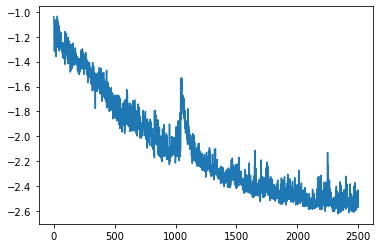

In [4]:
plt.plot(np.log10(losses))

In [5]:
seed_3 = seed.clone()
seed_3[4,32,32] = 0.5

In [7]:
with torch.no_grad():
    out = model(seed_2[None,:],1024,keep_history=True)
    video = model.history.cpu().detach()
    video = video[:,0,:4]
    video = video.transpose(1,3)

from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
